# Automated Feature Extraction using Pliers
*written by Alejandro de la Vega*

This tutorial provides an introduction to the automated extraction of features from multi-modal naturalistic stimuli for use as regressors in event-related analyes. We will be using *pliers*, a Python library which provides a unified, standardized interface to dozens of different feature extraction tools and services, including state-of-the-art deep learning models. 

### In this lab we will cover:

 - Installation and getting started
 - Pliers fundamentals
 - Extracting features
 - Converting stimuli across modalities
 - Chaining converters and feature extractors manually
 - Speech to Text Conversion using APIs
 - Speech / Text based extractors
 - Complex workflow managment using Pliers Graph API

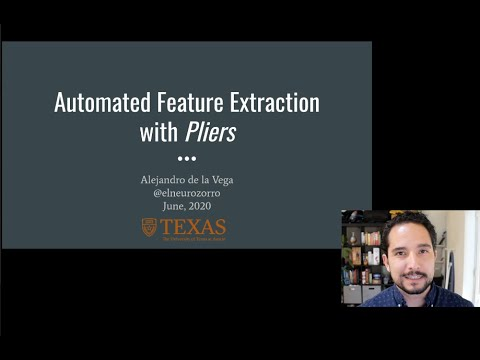

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('4mQjtyQPu_c')

# Why use Pliers for automated feature extraction?

Naturalistic fMRI paradigms have gained popularity due to their potential to more closely resemble the complex, dynamic nature of real-world perception. Due to their very *nature*, however, these complex stimuli pose serious practical challenges to analyze. Manual annotation is effortful and timeconsuming, and does not scale to capture the wide range of perceptual dynamics present in these stimuli. 

Fortunately, recent advancements in machine learning have made it possible to rapidly and automatically annotate multi-modal stimuli with a wide range of algorithms. Extracted features range from low-level perceptual features (such as brightness and loudness), to complex, psychological relevant features such as predictions from state-of-the-art language comprehension models. The timecourses of these extracted features can then be used as regressors in task-based fMRI analysis.

A consequence of the variety of potential features available, however, is that the interfaces to these various algorithms, and content analysis APIs are highly heterogenous. Simply installing and writing the code necessary to interface and harmonize these algorithms can be a substantial endeavour. _Pliers_ aims to facilitate the process by providing a uniform interface to a wide range of tools under an easy to use and unified Python framework. 

# Installation

Installating the base *pliers* package is simple, just use pip:

    pip install -U pliers

```{note}
As pliers interfaces with dozens of external libraries, there are many __optional dependencies__ that are not installed by default to keep the installation light.
Pliers will prompt you with installation instructions if you try to use an extractor that is not yet installed. 
```

### Naturalistic Stimuli from `ParanoiaStory` and `Sherlock`

We'll be working with the first run stimuli from the `ParanoiaStory` and the `Sherlock` datasets.

`ParanoiaStory` is an audio narrative, while `Sherlock` is a an audio-visual episode from a TV show.

Let's set up the paths of these stimuli and take a quick look at what we're dealing with.

In [11]:
# First set up stimuli paths
paranoia_audio = 'story1_audio.wav'
sherlock_video = 'Sherlock.m4v'


# Getting Started

The best way to see what *pliers* can offer is to jump right into an example. 

## Example 1: Audio RMS

A measure that is likely to capture a large amount of variance in auditory cortex activity during naturalistic stimulation is the power of the signal in the auditory track. A simple way to measure this is by extracting the `Root-Mean-Square (RMS)` of the audio signal across time.

*Pliers* makes this very easy. All we need to do is to import the `RMSExtractor` object, and apply it to the `ParanoiaStory` audio stimulus. 

In [12]:
from pliers.extractors import RMSExtractor

# Create an instance of this extractor
ext = RMSExtractor()

# Extract features from the audio stimulus
rms_result = ext.transform(paranoia_audio)

/home/zorro/anaconda3/envs/pliers/lib/python3.8/site-packages/moviepy/audio/AudioClip.py:113: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return stacker(self.iter_chunks(fps=fps, quantize=quantize,


The Extractor returns an `ExtractorResult` object which contains the extracted values. 

We can easily convert this to a *Pandas DataFrame*, a familar format that could easily be fed into a data-analysis pipeline, and is easy to inspect.

In [13]:
rms_df = rms_result.to_df()
rms_df

,order,duration,onset,object_id,rms
0,0,0.01161,0.000000,0,0.000743
1,1,0.01161,0.011610,0,0.000776
2,2,0.01161,0.023220,0,0.000823
3,3,0.01161,0.034830,0,0.001723
4,4,0.01161,0.046440,0,0.001852
...,...,...,...,...,...
45124,45124,0.01161,523.888617,0,0.001724
45125,45125,0.01161,523.900227,0,0.001554
45126,45126,0.01161,523.911837,0,0.001431
45127,45127,0.01161,523.923447,0,0.001311


We can then easily plot the timeline of `rms` across time for the *ParanoiaStory* study.

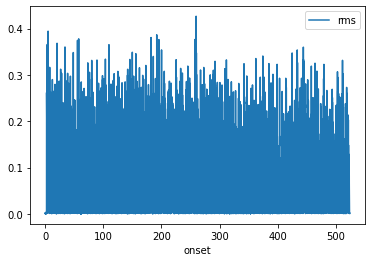

In [18]:
rms_df.plot('onset', 'rms')

We can now do the same thing for the *Sherlock* video stimulus, using the same `RMSExtractor`.

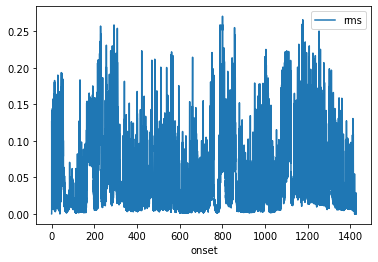

In [13]:
ext.transform(sherlock_video).to_df().plot('onset', 'rms')

That was easy! We can now see that the RMS profile of `Sherlock` is very different from the `ParanoiaStory` narrative. 


##### But, wait. How were we able to apply `RMSExtractor` to a *video* when this is an *audio*  Extractor?

Under the hood, *pliers* noticed this mismatch, and automatically converted the Sherlock video clip to an audio stimuli by extracting the audio track. As a result, the `RMSExtractor` *just worked* and returned to you the result you were expecting. 

Before we can understand how *pliers* does this, and how you can do this with greater manual control, it's important to first understand some basic concepts.

# Fundumentals of Pliers
This section is adapted from the [*pliers* documentation](http://tyarkoni.github.io/pliers/basic-concepts.html). For a more in-depth dive, see the official documentation.

[Insert Video Here]

## Stims and Transformers

*Pliers* is deliberately designed with simplicity in mind, and loosely modeled after usage patterns in *scikit-learn*. 

At its core, *pliers* is based around two kinds of objects: the `Stim`, and the `Transformer`. 

A `Stim` is a container for a data object we want to extract features from-- for example, the `Sherlock` video clip or the `ParanoiaStory` audio clip. 


```{note}
If you pass a string path to the `transform` method of an `Extractor`, *pliers* will attempt to automatically load the stimulus. This automatical detection is not fool proof, however, so explicilty loading the stimuli can be useful.

```

A `Transformer` provides functionality to *do something with* `Stims`–either to change the input Stim in some way (e.g., converting a `Stim` from video to audio), or to extract feature data from it (such as extracting `rms` from an audio stimulus).

Let's modify the previous example to explicitly load our stimuli:

In [14]:
from pliers.stimuli import AudioStim
from pliers.extractors import RMSExtractor

stim = AudioStim(paranoia_audio)
ext = RMSExtractor()
rms_features = ext.transform(stim)

We can see the separation between the target of the feature extraction (the *ParanoiaStory* `AudioStim`), and the `RMSExtractor` object that *transforms* this stimulus into an `ExtractorResult`. 

This basic pattern persists throughout *pliers*, no matter how many Transformers we string together, or how many Stim inputs we feed in.

### Types of Transformers

There are three types of `Transformers` in *pliers*, and all take `Stim` objects as inputs.
    
- `Extractors` return extracted feature data as `ExtractorResult` objects (which can be converted to a pandas dataframes).
  
  We have already seen an example of this with `RMSExtractor`, but there are dozens more in *pliers*.
  

- `Converters` take a `Stim`, and convert it to a different type of `Stim`. 

  For example, the `VideoToAudioConverter` takes a `VideoStim` as input, and returns an `AudioStim` with ony the audio track as output.


- `Filters` take a `Stim`, and return a *modified* `Stim` of the *same type*. 

  For example, the `ImageCroppingFilter` takes an `ImageStim` as input, and returns another `ImageStim` as output, where the image data stored in the `Stim` has been cropped by a bounding box specified by the user. 
  
```{note}
A [complete listing](http://tyarkoni.github.io/pliers/transformers.html#) of all `Transformers` is available in the offical *pliers* documentation
```

In practice, users will __primarily interact__ with `Extractors`, as *pliers* will automatically convert stimuli prior to extraction, greatly reducing the complexity of the code. 

However, it's often useful to manually combine these operations to fully control the process.

##  Example 2: Manual stimulus conversion + RMSExtractor

In __Example 1__, we applied the `RMSExtractor` to a the `Sherlock` video stimulus, and *pliers* automatically converted the stimulus from `VideoStim` to an `AudioStim` containing only the audio track.

Let's modify this example, to use manual conversion from Video to Audio:

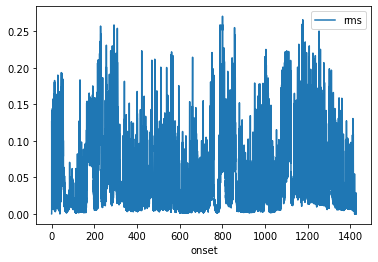

In [15]:
from pliers.converters import VideoToAudioConverter
from pliers.extractors import RMSExtractor

# Set up Extractor and Converter
conv = VideoToAudioConverter()
ext = RMSExtractor()

# Transform Video to Audio
audio_only = conv.transform(sherlock_video)
# Transform Video to RMS results
audio_result = ext.transform(audio_only)

audio_result.to_df().plot('onset', 'rms')

As you can see, the results are identical to letting pliers handle the conversation.

## Example 3: Face detection, frame sampling, and chaining Transformers

There are times when we need to specify the conversion parameters, and thus prefer not to rely in Pliers's automatic conversion. We can accomplish this by manually chaining a `Converter` to an `Extractor`

In this example, we'll be using the `FaceRecognitionFaceLocationsExtractor` to detect faces in the `Sherlock` video stimulus. 
This extractor provides an interface to the `face_recognition` python package. 

In [158]:
from pliers.extractors import FaceRecognitionFaceLocationsExtractor

# Using the more accurate 'cnn' model, change this to 'hog' for faster perfomance
face_ext = FaceRecognitionFaceLocationsExtractor(model='cnn')

# This extractor expects ImageStim as input
face_ext._input_type

pliers.stimuli.image.ImageStim

If we use this extractor to transform a `VideoStim`, *pliers* will implicitly use the `FrameSamplingConverter`.

However, it will do so with the default parameters, which in this case would extract every frame.
This is too fine grained, as we want to save ourselves the computation, and only sample infrequently for this example.

To convert the `Sherlock` stimuli from video, to `ImageStim` frames sampled at 0.1Hz (i.e., one frame every 10 seconds), we need to:

First, load the `VideoStim`, and use the `FrameSamplingFilter` to subsample this set of `ImageStims` at 0.1hz.

In [157]:
from pliers.stimuli import VideoStim
from pliers.filters import FrameSamplingFilter

video = VideoStim(sherlock_video)

# Sample at 0.1 Hz
filt = FrameSamplingFilter(hertz=0.1)
selected_frames = filt.transform(video)

# Number of sampled frames
selected_frames.n_frames

143

```{note}
`FrameSamplingFilter` expects a *collection* of `ImageStims` as input, and returns a subsampled collection of `ImageStims`. However, here it can take `VideoStim` as input, as *pliers* will *impliclty* convert `VideoStim` -> `ImageStim`. Since there are no important parameters to modify in this step, we can let *pliers* handle it for us, instead of doing it explicitly.
```

Next, we can use the `FaceRecognitionFaceLocationsExtractor` to detect and label face locations in the subset of frames

Note that since we transformed a collection of frames, the result of this operation is a *list* of `ExtractedResult` objects.

To merge these objects into a single pandas DataFrame, we can use the helper function `merge_results`

In [32]:
from pliers.extractors import merge_results
from pliers import config
# Disable progress bar for Jupyter Book
config.set_option('progress_bar', False)


# Detect faces in selected frames
face_features = face_ext.transform(selected_frames)
merged_faces = merge_results(face_features, metadata=False)

# Show only first few rows
merged_faces.head(12)

NameError: name 'face_ext' is not defined

In [147]:
len(merged_faces.onset.unique())

89

There are 89 unique onsets, which indicates that faces were found in 89/143 frames.

The `FaceRecognitionFaceLocationsExtractor#face_locations` column also indicates the location of each face in CSS order (i.e., top, right, bottom, left).


```{tip}
In some frames (e.g. 240s), multiple faces were found, and there are multiple rows for a given `onset`. To disambiguate these rows, *pliers* assigns each occurace a unique `object_id` column vale. Read more](http://tyarkoni.github.io/pliers/results.html#understanding-object-ids) about *object_id*.
```

Now, Let's plot all of these frames where faces were found!

In [143]:
# Filter selected frames to only include those with faces
# and extract stimulus "data" (numpy representation of image frame) from the ExtractorResult object
face_frames = [f.data for f in selected_frames if f.onset in merged_faces.onset.tolist()]

In [124]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_img_grid(img_list, shape, figsize=(30., 30.)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.1)

    for ax, im in zip(grid, img_list):
        ax.imshow(im)

    plt.show()

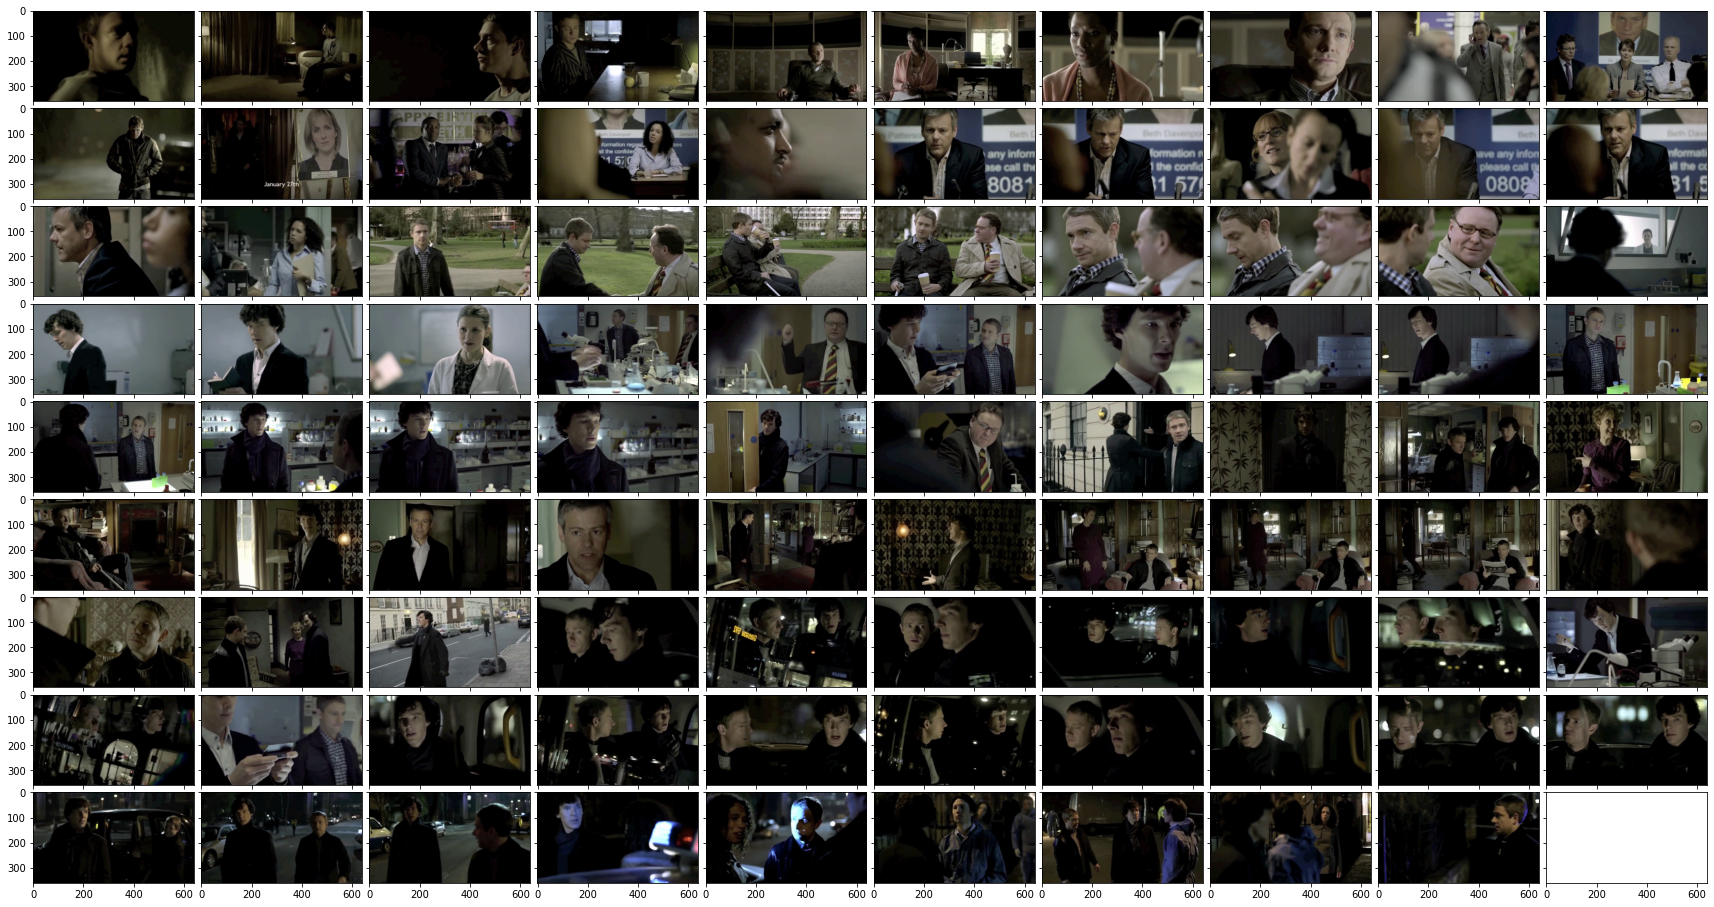

In [148]:
plot_img_grid(face_frames, (10, 9))

Now, let's take a look at the frames *without* a detected face

In [134]:
nonface_frames = [f.data for f in selected_frames if f.onset not in merged_faces.onset.tolist()]

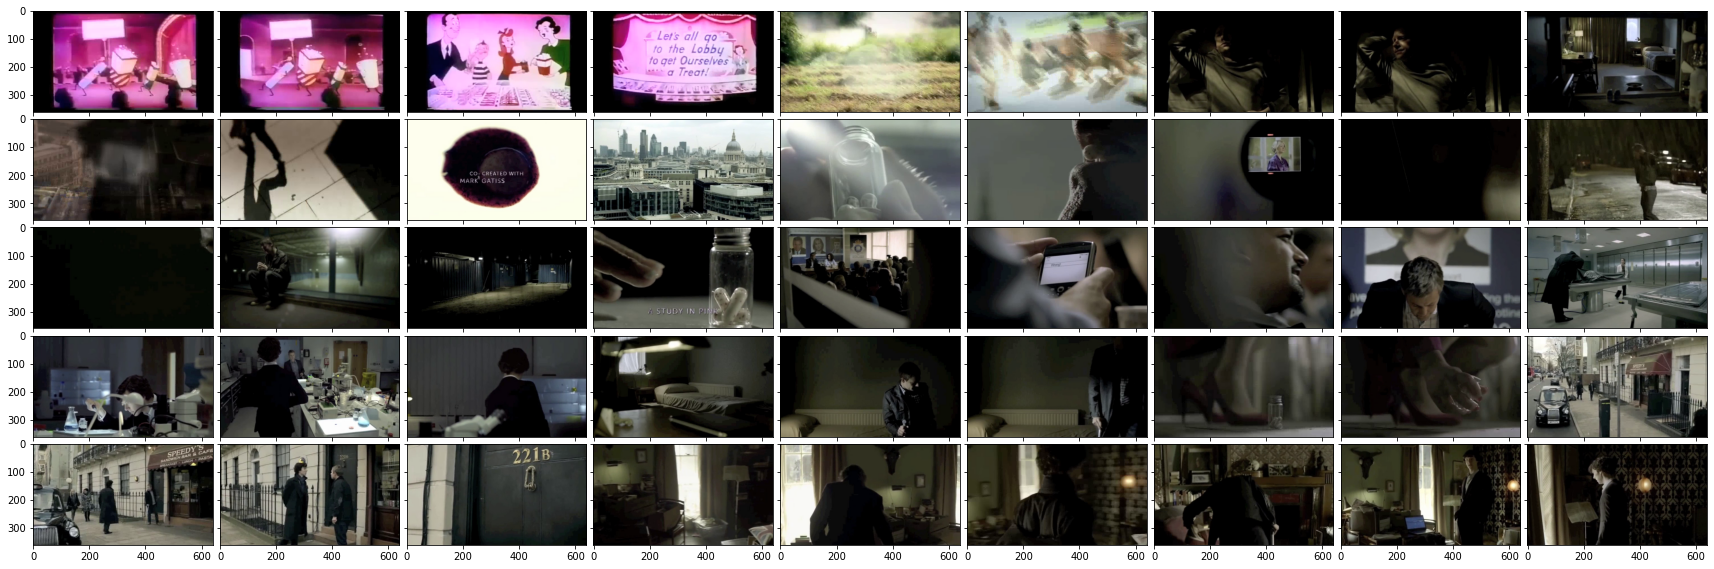

In [137]:
plot_img_grid(nonface_frames, (5, 9))

Great, for the most part it looks like the algorithm corrently idenitfied frames with visble faces, with occasional misses when faces were small.

## When to use implicit conversion?

Now that you know how to manually convert stimuli, you may wonder, when should I use manual conversion, and when should I rely on *implicit conversion*?

Pliers will always attempt implicit conversion when there is a mismatch between the input, and the expected input to a `Transformer`. If in doubt, inspect the `_input_type` attribute of an `Extractor`. 

In [150]:
face_ext._input_type

pliers.stimuli.image.ImageStim

`ExtractedResult` objects also keep a history of what was done prior to Extraction, which you can always inspect

In [156]:
str(face_features[0].history)

'VideoStim->FrameSamplingFilter/VideoFrameCollectionStim->VideoFrameCollectionIterator/VideoFrameStim->FaceRecognitionFaceLocationsExtractor/ExtractorResult'

```{note}
You can learn more about Transformation history in the [pliers docs](http://tyarkoni.github.io/pliers/stimuli.html#transformation-history)
```

If in doubt, simply chain `Converters` to `Extractors` manually.

If you want to learn more implict conversion, this topic is discussed in the [Pliers documentation](http://tyarkoni.github.io/pliers/transformers.html#implicit-stim-conversion).

# Speech-to-text Converters

So far, we have experimented with extracting features from `AudioStim` and `VideoStim`s. However, many naturalistic datasets feature extensive human speech, which likely drives a substantial amount of brain activity.

However, to analyze the speech language, we need a precisely aligned transcript of speech. 

Recent advancements in deep convolutional networks have spawned dozens of `speech-to-text` language models, that promise accurate, time-locked transcripts of speech. The best available models are currently paid services that can be accessed remotely using APIs. *pliers* has implemented support for several `speech-to-text` services (as well as image analysis APIs). For this example, we'll be using a service called `Rev.ai` to transcript run 1 of Paranoia Story to text.

## Example 4: Speech-to-Text Conversion with Rev.ai

### Remote service API Credentials

To use remote APIs, we need to give *pliers* our private credentials for these paid services, by setting the appropriate environment variable in our environment to the access key. For more details, [see here](http://tyarkoni.github.io/pliers/installation.html#api-keys)

For the sake of this tutorial, you can sign up for a free trial of [rev.ai](https://rev.ai) (5 hours free, no CC required). We have also provided a pre-extracted transcript that you can load instead.

Once signed up visit [https://www.rev.ai/access_token](https://www.rev.ai/access_token)_ to receive an access token, and set your token to the environment using the following command:

In [ ]:
import os
os.environ['REVAI_ACCESS_TOKEN'] = 'PRIVATE_KEY'

```{warning}
 Never share this token or push to GitHub!
```

Although we're using a machine-learning model to transcribe our audio file, *pliers* considers this a `Converter`, as we transform an `AudioStim` to a `ComplexTextStim`.

Let's try it out:

In [30]:
from pliers.converters import RevAISpeechAPIConverter
ext = RevAISpeechAPIConverter()

# Uncomment this line if you have set up the Rev.AI keys
# transcript = ext.transform(paranoia_audio)
# transcript.save('paranoia_story1_transcript.txt')

ModuleNotFoundError: No module named 'pliers.converters'

In [31]:
# For the sake of the demonstration, let's load an pre-existing transcript
from pliers.stimuli import ComplexTextStim
transcript = ComplexTextStim('paranoia_story1_transcript.txt')
transcript

As you can see, the `type` of `transcript` is `ComplexTextStim`. A `ComplexTextStim` is simply a container object that is composed of several `TextStim`s which represent individual words. Each individual `TextStim` element can then be associated with individual onsets and/or durations

In [6]:
# First first elements of the transcript
transcript.elements[:5]

In [24]:
# First word of the transcript
transcript.elements[0].text

'The'

In [25]:
# Specific onset for this word
transcript.elements[0].onset

2.09

```{tip}
*pliers* by default caches the result of `Extractors` in the background. If we were to re-run this `RevAISpeechAPIConverter` a second time on the same stimulus, it will simply used the cached results rather than perform a potentially expensive repeated API call. This caching behavior applies to all `Transformers` and can save needly re-extraction.
```

Let's take a closer look at the transcript by loading it as pandas DataFrame.

In [29]:
import pandas as pd
pd.read_table('paranoia_story1_transcript.txt').head(15)

,onset,text,duration
0,2.09,The,0.21
1,2.30,email,0.36
2,2.66,came,0.42
3,3.11,late,0.27
4,3.38,one,0.24
5,3.62,afternoon,0.69
6,4.55,as,0.18
7,4.73,dr,0.39
8,5.12,Carmen,0.39
9,5.51,Reed,0.33


In just a few minutes, and a few lines of code, we have a fairly accurate, precisely aligned transcript for `ParanoiaStory`. 

Now, what can we do with it?

## Example 5: Text-based Extractors

*pliers* offers support for dozens of `Extractors` that operate on `TextStims`. 

A light-weight and surprsingly useful approach is simply to annotate words using Dictionaries of established word norms. *pliers* makes this is easy using the `DictionaryExtractor`. 

A `DictionaryExtractor` simply maps words to arbitrary features encoded in a user-provided look up table. *pliers* comes with built-in support for several word-norm mappings using the [PredefinedDictionaryExtractor](http://tyarkoni.github.io/pliers/generated/pliers.extractors.PredefinedDictionaryExtractor.html#pliers.extractors.PredefinedDictionaryExtractor).

The predefined dictionaries built-in to *pliers* can be seen in the [repository](https://github.com/tyarkoni/pliers/blob/master/pliers/datasets/dictionaries.json). 

In this example, we're going to extract values for Age-of-aquisition (Kuperman, et al., 2012) and affective valence (Warriner,et al., 2013).

In [32]:
from pliers.extractors import PredefinedDictionaryExtractor

dictext = PredefinedDictionaryExtractor(
    variables= {
        "affect": ['V.Mean.Sum'],
        "aoa": ["AoA_Kup"]
    })

norms_results = dictext.transform(transcript)

Stim: 1376it [00:00, 1721.13it/s]


In [50]:
norms_df = merge_results(norms_results)
norms_df[['stim_name', 'onset', 'PredefinedDictionaryExtractor#affect_V.Mean.Sum', 
          'PredefinedDictionaryExtractor#aoa_AoA_Kup']].head(15)

,stim_name,onset,PredefinedDictionaryExtractor#affect_V.Mean.Sum,PredefinedDictionaryExtractor#aoa_AoA_Kup
0,text[email],2.30,6.00,11.520000
1,text[late],3.11,3.32,5.280000
2,text[one],3.38,6.09,3.227100
3,text[afternoon],3.62,6.68,4.650000
4,text[as],4.55,NaN,6.104490
5,text[in],6.38,NaN,3.685351
6,text[her],6.53,NaN,5.092075
7,text[office],6.68,4.54,6.680000
8,text[filling],7.43,NaN,6.818509
9,text[out],7.76,NaN,3.280385


In a single dataframe, we can see the input words, and the values for each of the two norms we requested.

```{note}
If a Dictionary does not include the requested word, it will be encoded as `NaN` value. If both dictionaries are missing the word, it will be dropped when merging.
```

# Graph API: Managing complex workflows

__Congratulations__ At this point, you should now enough to take advantage of the majority *pliers* has to offer.

But, with great power comes great responsibilty... or rather, complex workflows. 

Say you want to extract various features on the `Sherlock` dataset, which require distinct conversion steps. You could do as we have so far, and string together various `Transformers` and manually connect them, but this can become cumbersome, and verbose. 

For example, suppose we want to extract both visual and speech transcript-based features from the `Sherlock` dataset. Specifically, let’s say we want to encode the visual brightness of each frame and detect faces. We also run a sentiment analysis model on a speech transcription extracted from the audio track of the videos. We also want to extract frequency norms on each transcribed word. This requires us to do all of the following:

   - Convert the video to a series of video frames, using FrameSamplingFilter;
   - Run a brightness extractor on each image frame;
   - Detect faces for each frame;
   - Extract the audio track from the video;
   - Transcribe the audio track to text;
   - Run a sentiment analysis model (in this case, using the Vander sentiment extractor) on the transcribed text.
   - Run a Predefined dictionary extractor on the transcribed text
   
Using the normal pliers API, the code to run these steps would look like this

```
from pliers.stimuli import VideoStim
from pliers.filters import FrameSamplingFilter
from pliers.converters import RevAISpeechAPIConverter
from pliers.extractors import (VADERSentimentExtractor, FaceRecognitionFaceLandmarksExtractor)

stimulus = VideoStim(sherlock_video)

# Sample 2 video frames / second
frame_filter = FrameSamplingFilter(hertz=0.1)
frames = frame_filter.transform(stimulus)

# Face extraction
face_ext = FaceRecognitionFaceLandmarksExtractor()
face_results = face_ext.transform(frames)

# STFT Extraction
stft_ext = STFTAudioExtractor(freq_bins=[(100, 300)])
stft_res = stft_ext.transform(stimulus)

# Run the audio through RevAI's text detection API
transcriber = RevAISpeechAPIConverter()
transcripts = transcriber.transform(stimulus)

# Apply Vader sentiment analysis extractor
sentiment = VADERSentimentExtractor()
sentiment_results = sentiment.transform(transcripts)

# Apply PredefinedDictionaryExtractor
dict_ext = PredefinedDictionaryExtractor(['affect/V.Mean.Sum',
                                         'subtlexusfrequency/Lg10WF'])
dict_results = dict_ext.transform(transcripts)

# Combine visual and text-based feature data
results = face_results + [stft_res] + sentiment_results + dict_results

# # Merge into a single pandas DF
df = merge_results(results)
```

The above code really isn’t that bad–it already features a high level of abstraction (each Transformer is initialized and applied in just two lines of code!), and has the advantage of being explicit about every step. Nonetheless, if we want to save ourselves a few dozen keystrokes, we can use pliers’ Graph API to abbreviate the listing down to just this:

```
from pliers.graph import Graph

# Define nodes
nodes = [
    (FrameSamplingFilter(hertz=0.1),
         ['FaceRecognitionFaceLandmarksExtractor', 'BrightnessExtractor']),
    (STFTAudioExtractor(freq_bins=[(100, 300)])),
    ('RevAISpeechAPIConverter',
         [PredefinedDictionaryExtractor(['affect/V.Mean.Sum','subtlexusfrequency/Lg10WF']),
          'VADERSentimentExtractor'])
]

# Initialize and execute Graph
g = Graph(nodes)

# Arguments to merge_results can be passed in here
df = g.transform(sherlock_video)
```

This short example demostrates a powerful way to express complex extraction workflows in *pliers*.

If you'd like to learn more about the Graph API, you can head over to the [documentation](http://tyarkoni.github.io/pliers/graphs.html).

# Where to go from here?

*Pliers* is a powerful, yet easy to use Python library for multi-modal feature extraction. In this short tutorial, you've seen how to use *pliers* to modify, convert and extract features from stimuli. 


To see the full range of `Transformers` implemented in *pliers*, [refer to this listing](http://tyarkoni.github.io/pliers/transformers.html) 

What's most exciting about *pliers*, and the quickly evolving landscape of feature algorithms is that they are constantly evolving. New developments promise to allows to extract ever more psychologically relevant features from naturalistic stimuli, automatically. 

To that end, *pliers* is designed to be easily expanded by open-source contributions. If you have any ideas for future extractors, or simply find a bug to report, head over to our GitHub repository and [file and issue](https://github.com/tyarkoni/pliers/issues).